In [1]:
import numpy as np
import argparse
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # use CPU only
import glob
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from resizeimage import resizeimage
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import np_utils
from keras import backend as K

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# limit GPU memory use
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = "0" #only the gpu 0 is allowed
#set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
SOURCE_IMG_WIDTH = 80
SOURCE_IMG_HEIGHT = 80
datapath = 'D:\\FontImageGenerator\\TextImageGenerator\\TextImageGenerator\\bin\\Release\\Output\\'

valid_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, preprocessing_function=preprocess_input,
                                   shear_range=0.0, horizontal_flip=False, fill_mode="wrap", 
                                   data_format='channels_last')

valid_generator = valid_datagen.flow_from_directory(
    directory=datapath + 'Validate\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=200,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

model = models.load_model('all_freezed_vgg19_tf18_best89preProc.h5')

Found 203342 images belonging to 347 classes.


(80, 80, 3)
(80, 80, 3)
HanYi_HYZhangZiShanTiW


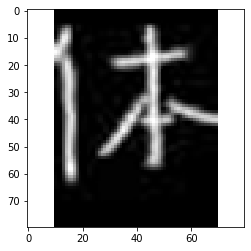

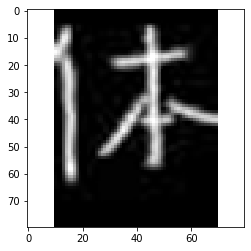

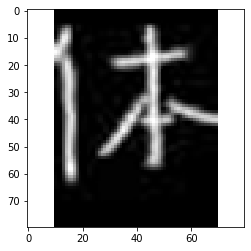

In [6]:
#path= "D:\\FontImageGenerator\\TextImageGenerator\\TextImageGenerator\\bin\\Release\\Output\\"
path= "D:\\ImageFontFinder\\ImageFontFinder\\bin\\Debug\\TestImage\\"
path += "z7.png"

img = Image.open(path).convert("RGB")
nimg = np.asarray(img)
plt.figure()
plt.imshow(img)
print(nimg.shape)

basewidth = 80
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img0 = img.resize((basewidth,hsize), Image.LANCZOS)
plt.figure()
plt.imshow(img0)

#plt.figure()
#plt.imshow(Image.open("D:\\ImageFontFinder\\ImageFontFinder\\bin\\Debug\\TestImage\\t2.1.png").convert("RGB"))

img2 = resizeimage.resize_contain(img0, [80,80]).convert('LA').convert("RGB")

nimg2 = np.asarray(img2)
print(nimg2.shape)
plt.figure()
plt.imshow(img2)

if (True):
    imarray = preprocess_input(np.array([nimg2]))

    cls = model.predict_classes(imarray)
    class_prob = model.predict_proba(imarray)
    #print(class_prob)
    res_array = np.reshape(class_prob,347)

    np.set_printoptions(suppress=True)
    np.savetxt("prob.csv",res_array,delimiter=",")

    # Get the filenames from the generator
    fnames = valid_generator.filenames
    # Get the ground truth from generator
    ground_truth = valid_generator.classes
    # Get the label to class mapping from the generator
    label2index = valid_generator.class_indices
    # Getting the mapping from class index to class label
    idx2label = dict((v,k) for k,v in label2index.items())

    print(idx2label[cls[0]])

(1, 80, 80, 3)

===== output predicted results =====

[[0.         0.00005454 0.         0.         0.03106803 0.
  0.         0.         0.         0.         0.         0.
  0.00000005 0.         0.         0.         0.         0.00000034
  0.         0.         0.00000459 0.         0.00165595 0.00000236
  0.00000008 0.         0.         0.0000005  0.         0.
  0.00008042 0.         0.         0.         0.00000166 0.
  0.         0.         0.         0.         0.         0.00000003
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00060432 0.         0.00002719 0.         0.         0.
  0.         0.         0.         0.         0.         0.00000002
  0.         0.         0.         0.         0.         0.00000035
  0.         0.00000002 0.         0.00000006 0.00718011 0.
  0.00000045 0.         0.         0.00000106 0.         0.
  0.         0.         0.         0.         0.         0.0000007

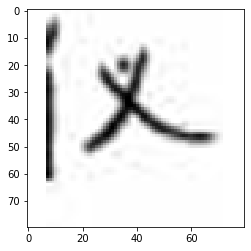

In [77]:
from tensorflow.python.platform import gfile
from keras.applications.vgg19 import preprocess_input
GRAPH_PB_PATH = './all_freezed_vgg19_tf18.pb'
#img = Image.open('D:\\FontImageGenerator\\TextImageGenerator\\TextImageGenerator\\bin\\Release\\Output\\Test\\Test_folder\\0_Microsoft YaHei_264_.png')
img = Image.open('D:\\ImageFontFinder\\ImageFontFinder\\bin\\Debug\\TestImage\\z2.png')
img = resizeimage.resize_contain(img, [80, 80]).convert('LA').convert("RGB")
plt.imshow(img)
nimg = np.asarray(img)
imarray = np.array([nimg2])
#imarray = preprocess_input(np.array([nimg]))
print(imarray.shape)

with tf.Session() as sess:
    # load model from pb file
    with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)
        
    # write to tensorboard (check tensorboard for each op names)
    writer = tf.summary.FileWriter('./log/')
    writer.add_graph(sess.graph)
    writer.flush()
    writer.close()
    
    # print all operation names 
    #print('\n===== ouptut operation names =====\n')
    
    #fb = open("graph.txt","w")
    #for op in sess.graph.get_operations():
    #    fb.write(str(op))
    #fb.close()
    
    # inference by the model (op name must comes with :0 to specify the index of its output)
    tensor_output = sess.graph.get_tensor_by_name('import/dense_2/Softmax:0')
    tensor_input = sess.graph.get_tensor_by_name('import/vgg19_input:0')
    predictions = sess.run(tensor_output, {tensor_input: imarray})
    print('\n===== output predicted results =====\n')
    print(predictions)

In [78]:
print(idx2label[np.argmax(predictions, axis=1)[0]])
print(np.argmax(predictions, axis=1))
print(predictions[0][np.argmax(predictions, axis=1)[0]])

HanYi_HYZhangZiShanTiW
[202]
0.9075618
